## FPN Model Architecture



The FPN (Feature Pyramid Network) semantic segmentation model is a deep learning architecture commonly used for pixel-wise image segmentation tasks. It was introduced by Lin et al. in their [paper](https://arxiv.org/abs/1901.02446) "Feature Pyramid Networks for Object Detection" in 2017.

The main idea behind FPN is to address the challenge of object segmentation at different scales in an image. It aims to capture both fine-grained details and high-level context information to improve the accuracy of segmentation.

FPN incorporates a top-down pathway and a lateral connection pathway. The top-down pathway involves progressively downsampling the input image to generate a feature pyramid with multiple scales. The lateral connection pathway connects feature maps from different scales to ensure the fusion of information across different levels.

The FPN model utilizes a backbone network, such as ResNet or VGG, to extract features from the input image. These features are then passed through the top-down and lateral connection pathways to generate a set of feature maps at different scales. These feature maps are combined to form a feature pyramid, which is then fed into a segmentation head to predict pixel-wise class labels or masks.

By leveraging the multi-scale feature pyramid, the FPN model can effectively handle objects of various sizes and capture both local and global context information. This makes it particularly suitable for tasks like semantic segmentation, where accurate object delineation is crucial.

Overall, the FPN semantic segmentation model has been widely adopted and achieved state-of-the-art performance on various benchmark datasets, demonstrating its effectiveness in tackling pixel-wise segmentation tasks.

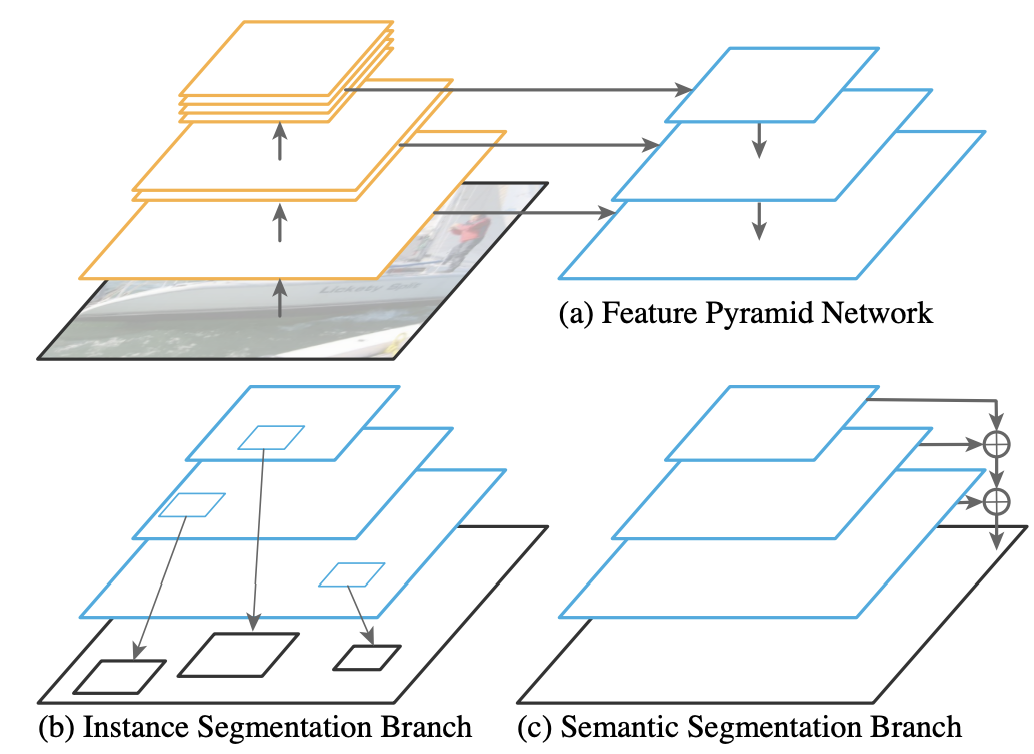

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
class FPN(nn.Module):
    def __init__(self, num_classes):
        super(FPN, self).__init__()
         # Load the backbone model (e.g., ResNet50)
        self.backbone = models.resnet50(pretrained=True)
         # Feature pyramid network
        self.pyramid_layers = nn.ModuleList([
            nn.Conv2d(256, 256, kernel_size=1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.Conv2d(1024, 256, kernel_size=1),
            nn.Conv2d(2048, 256, kernel_size=1)
        ])
        self.smoothing_layers = nn.ModuleList([
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1)
        ])
        self.predictor = nn.Conv2d(256, num_classes, kernel_size=3, padding=1)
    def forward(self, x):
        # Backbone feature extraction
        features = self.backbone.conv1(x)
        features = self.backbone.bn1(features)
        features = self.backbone.relu(features)
        features = self.backbone.maxpool(features)
        c2 = self.backbone.layer1(features)
        c3 = self.backbone.layer2(c2)
        c4 = self.backbone.layer3(c3)
        c5 = self.backbone.layer4(c4)
         # Feature pyramid network
        p5 = self.pyramid_layers[3](c5)
        p4 = self.smoothing_layers[2](self.pyramid_layers[2](c4) + nn.functional.interpolate(p5, scale_factor=2, mode='nearest'))
        p3 = self.smoothing_layers[1](self.pyramid_layers[1](c3) + nn.functional.interpolate(p4, scale_factor=2, mode='nearest'))
        p2 = self.smoothing_layers[0](self.pyramid_layers[0](c2) + nn.functional.interpolate(p3, scale_factor=2, mode='nearest'))
         # Final prediction
        output = self.predictor(p2)
        return output